In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dfo=pd.read_csv('properatti.csv')

In [3]:
dfo.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

# Enfoque

Queremos enfocarnos en

-  departamentos
-  en Capital Federal
-  denominados en USD

y de ellos analizar

-  el barrio ('place_name', 'lat', 'lon')
-  el precio por metro cuadrado ('price', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2')
-  ??expensas ('expenses')
-  datos extraíbles de la descripción ('description', 'title', 'rooms')

Gran parte de la información está faltante, por lo cual hay que aprovechar redundancias en los datos pare inferirla

In [4]:
dfo.isnull().sum()/len(dfo)

Unnamed: 0                    0.000000
operation                     0.000000
property_type                 0.000000
place_name                    0.000190
place_with_parent_names       0.000000
country_name                  0.000000
state_name                    0.000000
geonames_id                   0.154405
lat-lon                       0.425260
lat                           0.425260
lon                           0.425260
price                         0.168372
currency                      0.168380
price_aprox_local_currency    0.168372
price_aprox_usd               0.168372
surface_total_in_m2           0.324435
surface_covered_in_m2         0.164222
price_usd_per_m2              0.433947
price_per_m2                  0.276869
floor                         0.934837
rooms                         0.609058
expenses                      0.882346
properati_url                 0.000000
description                   0.000016
title                         0.000000
image_thumbnail          

## Paso 1: Capital Federal

Se encuentra en la variable 'state_name' y representa la mayor zona geográfica en el dataset

In [5]:
dfo['state_name'].value_counts()

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

## Paso 2: departamentos

Si la propiedad es una casa, un departamento, un PH o un negocio se alamcena en la columna 'property_type'. Dentro de Capital, hay un orden de magnitud más departamentos que casas en venta en el dataset

In [6]:
dfo.loc[dfo['state_name']=='Capital Federal', 'property_type'].value_counts()

apartment    27037
house         2087
PH            1828
store         1364
Name: property_type, dtype: int64

In [7]:
df1=dfo.loc[(dfo['state_name']=='Capital Federal')&(dfo['property_type']=='apartment')]

## Paso 3: moneda

La tercer restricción que queremos hacer al dataset es restringirnos a las propiedas denominadas en dólares, sin embargo esto requiere más análisis que los pasos anteriores, ya que la columna 'currency' presenta valores nulos que trataremos de llenar

In [8]:
df1['currency'].isnull().sum()/len(df1)

0.1066316529200725

Observemos entonces redundancias en los datos: hay tres columnas que indican el precio, que son 'price', 'price_aprox_local_currency', y 'price_aprox_usd'. ¿Podemos sacar algo de ésto?

In [9]:
len(df1[df1['currency'].isnull()])

2883

In [10]:
len(df1[(df1['currency'].isnull())&(df1['price'].isnull())])

2883

In [11]:
len(df1[(df1['currency'].isnull())&(df1['price_aprox_usd'].isnull())])

2883

**No**. Cuando 'currency' es nulo, 'price' y 'price_aprox_usd' también lo son. Consideremos entonces las columnas 'price_usd_per_m2' y 'price_per_m2', que podrían también tener información util

In [12]:
len(df1[(df1['currency'].isnull())&(df1['price_usd_per_m2'].isnull())])

2883

In [13]:
len(df1[(df1['currency'].isnull())&(df1['price_per_m2'].isnull())])

2883

Tampoco. Cuando 'currency' es nulo, no hay información de precios en el dataset. En conclusión, esas filas no nos sirven y no hay nada que podamos hacer con ellas. Podemos entonces quedarnos con el dataset restricto a precios denominados explícitamente en dólares

In [14]:
df2=df1[df1['currency']=='USD'].copy()

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23006 entries, 2 to 121219
Data columns (total 26 columns):
Unnamed: 0                    23006 non-null int64
operation                     23006 non-null object
property_type                 23006 non-null object
place_name                    23006 non-null object
place_with_parent_names       23006 non-null object
country_name                  23006 non-null object
state_name                    23006 non-null object
geonames_id                   22031 non-null float64
lat-lon                       17549 non-null object
lat                           17549 non-null float64
lon                           17549 non-null float64
price                         23006 non-null float64
currency                      23006 non-null object
price_aprox_local_currency    23006 non-null float64
price_aprox_usd               23006 non-null float64
surface_total_in_m2           18935 non-null float64
surface_covered_in_m2         21750 non-null float64

# Limpieza

Habiéndonos restringido a un subconjunto de interés del dataset, empecemos el proceso de limpiar los datos. Concetrémonos por ahora en la relación de las variables 'price', 'price_aprox_usd', 'surface_total_in_m2', 'price_usd_per_m2' y 'price_per_m2'. Algunas de éstas deberían ser iguales, otra cumplir relaciones matemáticas entre sí.

In [16]:
len(df2[df2['price']!=df2['price_aprox_usd']])

0

In [17]:
len(df2[df2['price_per_m2']!=df2['price_usd_per_m2']])

18179

'price' y 'price_aprox_usd' son iguales siempre, así que no perdemos nada con considerar sólo una de ellas. 'price_per_m2' y 'price_usd_per_m2' son diferentes en muchas filas, lo cual se debe en parte pero no en todo a que tienen muchos valores NaN. Sabemos que tienen que estar relacionadas con 'price' y 'surface_total_in_m2', así que miremos que obtenemos de eso

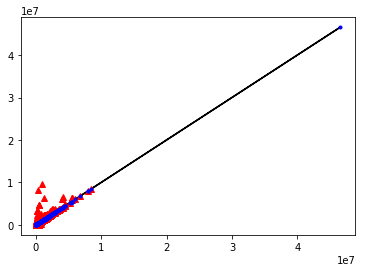

In [18]:
#linea negra, precio declarado
plt.plot(df2['price'],df2['price'], 'k-') 
#triangulos rojos, precio calculado en base a 'price_per_m2'
plt.plot(df2['price'],df2['price_per_m2']*df2['surface_total_in_m2'],'r^')
#puntos azules, precio calculado en base a 'price_usd_per_m2'
plt.plot(df2['price'],df2['price_usd_per_m2']*df2['surface_total_in_m2'], 'b.')


Vemos que el precio calculado en base a 'price_per_m2' * 'surface_total_in_m2' (triángulos rojos) difiere mucho del precio declarado (línea negra) en varios puntos. El precio calculado a base de 'price_usd_per_m2' parece ajustarse mucho mejor (vemos, de paso, un claro outlier en precio en el punto azul al extremo superior derecho)

Examinando con mas detalle 'price_usd_per_m2', vemos que no es exactamente igual a 'price'/'surface_total_in_m2', pero los errores son minúsculos:

In [19]:
len(df2[df2['price']/df2['surface_total_in_m2']!=df2['price_usd_per_m2']])

10053

In [20]:
diff=np.abs(df2['price']/df2['surface_total_in_m2']-df2['price_usd_per_m2'])
diff.max()

5.820766091346741e-11

Ahora bien, incluso decidiendo que nos quedamos con 'price_usd_per_m2', todavía tiene este valores NaN. Veamos qué podemos solucionar de eso:

In [21]:
df2['price_usd_per_m2'].isnull().sum()

4084

In [22]:
df2['price_usd_per_m2'].fillna(df2['price']/df2['surface_total_in_m2'], inplace=True)

In [23]:
df2['price_usd_per_m2'].isnull().sum()

4071

Ganamos muy poco, porque 'surface_total_in_m2' tiene sus propios NaN. Recordemos que 'price_per_m2', aunque tenía algunas diferencias importantes con 'price'/'surface_total_in_m2', también tenia coincidencias. ¿Podemos usarlo como un parámetro confiable?

In [24]:
len(df2[(df2['price_usd_per_m2'].isnull())&(~df2['price_per_m2'].isnull())])

3705